C:\Users\nouhs\AppData\Local\Temp\ipykernel_26740\3706045684.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Region', y='Priority', data=df_index, order=order, palette='coolwarm')


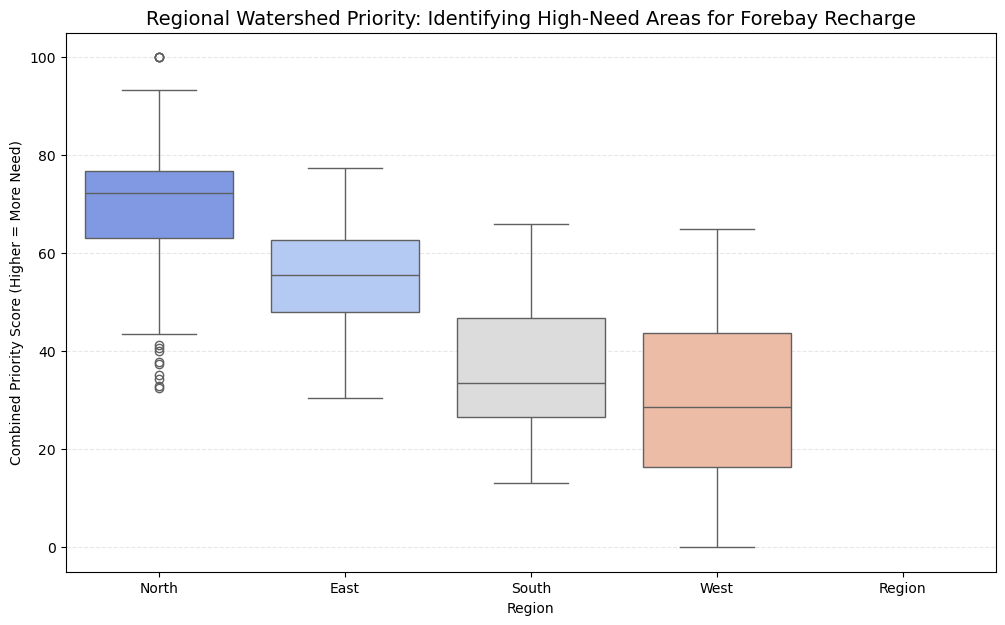

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# 1. LOAD DATA (Adjust paths based on your GitHub structure)
csv_url = "https://raw.githubusercontent.com/nouhy01/CWH-UCLA-Project/main/Data/Community%20Characteristics/Green_Schoolyards_Category_Indexes.csv"
forebays_url = "https://raw.githubusercontent.com/nouhy01/CWH-UCLA-Project/main/Data/Watershed/Hydrogeologic%20forebays.geojson"

try:
    df_index = pd.read_csv(csv_url)
    gdf_forebays = gpd.read_file(forebays_url)
    
    # Standardize column names (Handling those \n from your previous error)
    df_index.columns = df_index.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 2. SPATIAL CATEGORIZATION (For schools without coordinates)
    # If we can't map dots yet, we compare Region-wide scores vs. Forebay presence
    plt.figure(figsize=(12, 7))
    
    # We create a 'Combined Priority' metric
    df_index['Priority'] = pd.to_numeric(df_index['Combined Category 1 Score'], errors='coerce')
    
    # Recommended Visual: Boxplot of Priority Scores by LAUSD Region
    # This highlights which REGION needs the most watershed investment
    order = df_index.groupby('Region')['Priority'].median().sort_values(ascending=False).index
    sns.boxplot(x='Region', y='Priority', data=df_index, order=order, palette='coolwarm')
    
    plt.title('Regional Watershed Priority: Identifying High-Need Areas for Forebay Recharge', fontsize=14)
    plt.ylabel('Combined Priority Score (Higher = More Need)')
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

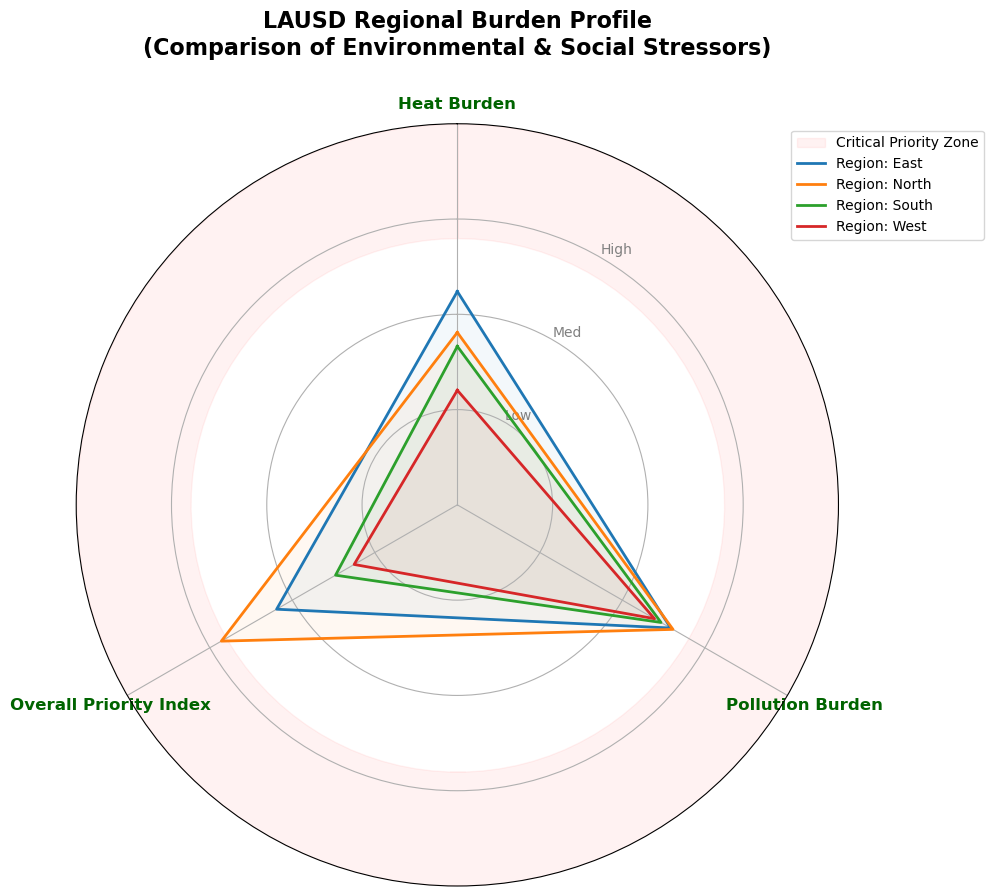

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. DATA SOURCE
url = "https://raw.githubusercontent.com/nouhy01/CWH-UCLA-Project/main/Data/Community%20Characteristics/Green_Schoolyards_Category_Indexes.csv"

try:
    df = pd.read_csv(url)
    df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # 2. SELECT & CLEAN METRICS
    metrics = [
        'Extreme Heat Temperature Score',
        'CalEnviroScreen Score',
        'Combined Category 1 Score'
    ]
    
    for col in metrics:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # 3. REGIONAL AGGREGATION
    df_regional = df.groupby('Region')[metrics].mean().dropna()

    # 4. RADAR SETUP
    categories = ['Heat Burden', 'Pollution Burden', 'Overall Priority Index']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    # Adjust layout so labels don't overlap
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Label the spokes
    plt.xticks(angles[:-1], categories, color='darkgreen', size=12, fontweight='bold')

    # Add a "Danger Zone" background fill
    # This colors the 70-100% range light red to indicate critical priority
    ax.fill_between(np.linspace(0, 2*np.pi, 100), 70, 100, color='red', alpha=0.05, label='Critical Priority Zone')

    # 5. PLOT EACH REGION
    for region in df_regional.index:
        values = df_regional.loc[region].values.flatten().tolist()
        values += values[:1]
        
        # Plot line
        line, = ax.plot(angles, values, linewidth=2, label=f"Region: {region}")
        # Fill area with very low alpha to keep it readable
        ax.fill(angles, values, alpha=0.05)

    # 6. ADDING EXPLANATORY LABELS (The "Stuff")
    # Label the scale
    ax.set_rlabel_position(30)
    plt.yticks([25, 50, 75], ["Low", "Med", "High"], color="grey", size=10)
    plt.ylim(0, 100)

    plt.title('LAUSD Regional Burden Profile\n(Comparison of Environmental & Social Stressors)', size=16, y=1.08, fontweight='bold')
    
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

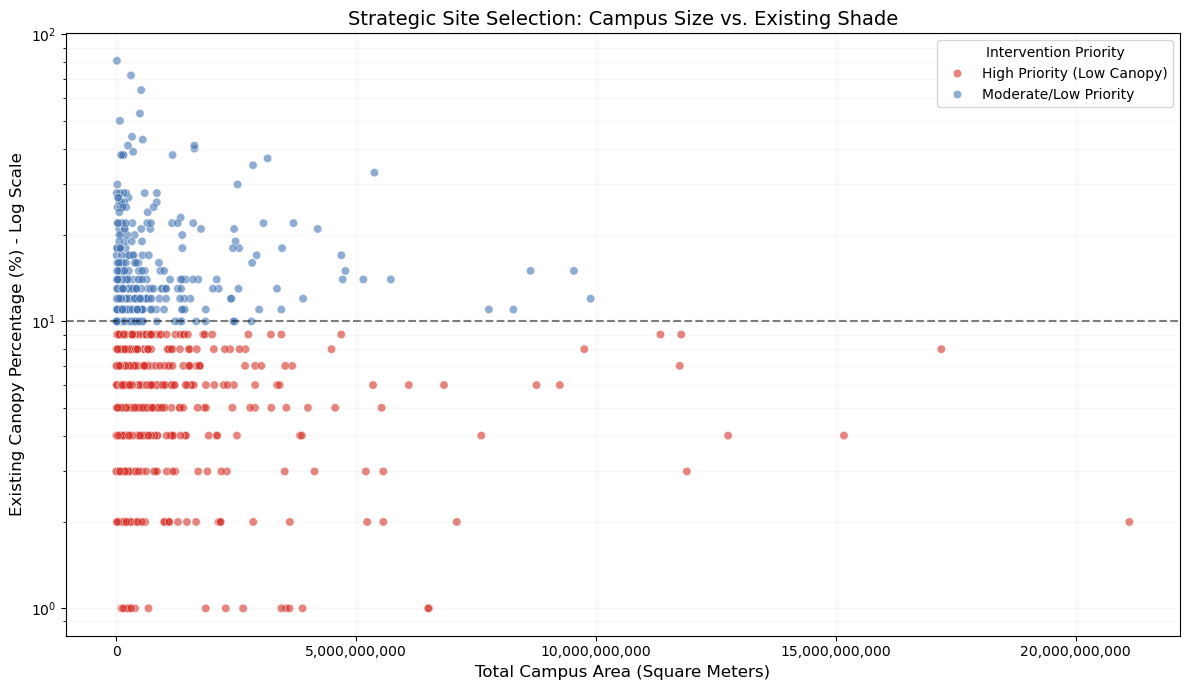

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. DATA SOURCE
canopy_url = "https://raw.githubusercontent.com/nouhy01/CWH-UCLA-Project/main/Data/School%20Canopy/school_canopy_data.csv"

try:
    df = pd.read_csv(canopy_url)
    
    # 2. DATA CLEANING
    df['Canopy_Pct'] = pd.to_numeric(df['STACNPPCTA'], errors='coerce')
    df['Campus_Area_M2'] = pd.to_numeric(df['SHAPE_AREA'], errors='coerce')
    
    # Filter for log scale compatibility (must be > 0)
    df_plot = df[df['Canopy_Pct'] > 0].copy()
    
    # 3. PRIORITY TAGGING
    df_plot['Status'] = df_plot['Canopy_Pct'].apply(
        lambda x: 'High Priority (Low Canopy)' if x < 10 else 'Moderate/Low Priority'
    )
    
    # 4. PLOT GENERATION
    plt.figure(figsize=(12, 7))
    ax = sns.scatterplot(
        x='Campus_Area_M2', 
        y='Canopy_Pct', 
        hue='Status', 
        palette={'High Priority (Low Canopy)': '#d73027', 'Moderate/Low Priority': '#4575b4'},
        alpha=0.6, 
        edgecolor='w',
        data=df_plot
    )

    # 5. LOG SCALE & FORMATTING
    plt.yscale('log')
    
    # Use commas for the x-axis to make square meters readable
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    
    plt.title('Strategic Site Selection: Campus Size vs. Existing Shade', fontsize=14)
    plt.xlabel('Total Campus Area (Square Meters)', fontsize=12) # Units updated to Meters
    plt.ylabel('Existing Canopy Percentage (%) - Log Scale', fontsize=12)
    
    plt.axhline(10, color='black', linestyle='--', alpha=0.5) 
    
    plt.legend(title='Intervention Priority')
    plt.grid(True, which="both", ls="-", alpha=0.1)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")

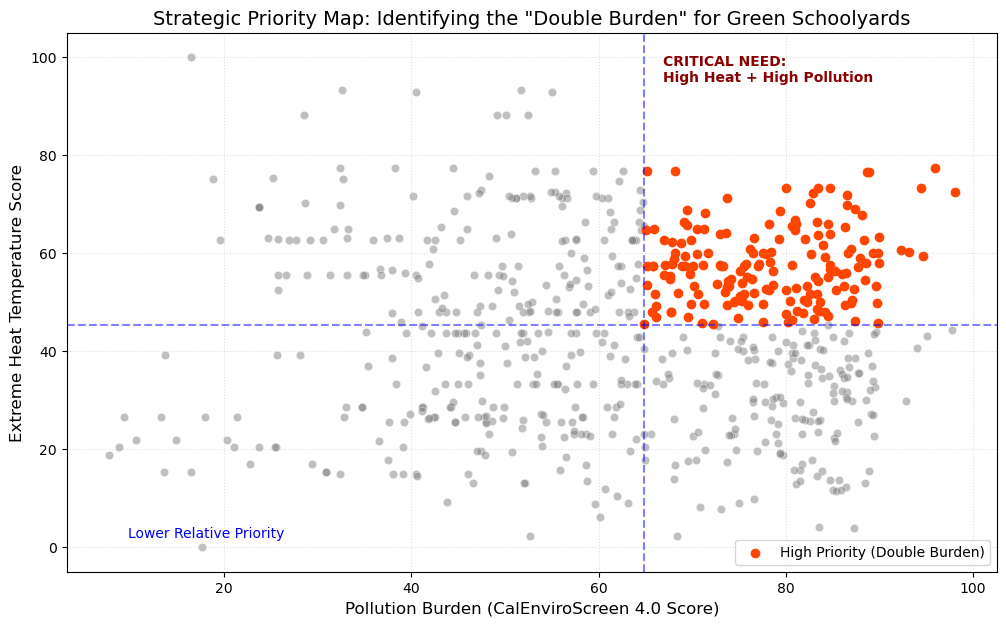

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. THE CORRECT RAW URL
url = "https://raw.githubusercontent.com/nouhy01/CWH-UCLA-Project/main/Data/Community%20Characteristics/Green_Schoolyards_Category_Indexes.csv"

try:
    df_schools = pd.read_csv(url)
    df_schools.columns = df_schools.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
    
    heat_col = [c for c in df_schools.columns if 'Heat' in c][0]
    equity_col = [c for c in df_schools.columns if 'CalEnviroScreen' in c][0]
    
    df_schools[heat_col] = pd.to_numeric(df_schools[heat_col], errors='coerce')
    df_schools[equity_col] = pd.to_numeric(df_schools[equity_col], errors='coerce')
    df_plot = df_schools.dropna(subset=[heat_col, equity_col])

    # --- THE UPGRADE: QUADRANT ANALYSIS ---
    heat_median = df_plot[heat_col].median()
    equity_median = df_plot[equity_col].median()

    plt.figure(figsize=(12, 7))
    
    # Scatter plot
    sns.scatterplot(x=equity_col, y=heat_col, data=df_plot, 
                    alpha=0.5, color='gray', edgecolor='w')

    # Highlight the 'Double Burden' schools in the top right
    high_priority = df_plot[(df_plot[heat_col] > heat_median) & (df_plot[equity_col] > equity_median)]
    plt.scatter(high_priority[equity_col], high_priority[heat_col], color='orangered', label='High Priority (Double Burden)')

    # Add Quadrant Lines
    plt.axvline(equity_median, color='blue', linestyle='--', alpha=0.5)
    plt.axhline(heat_median, color='blue', linestyle='--', alpha=0.5)

    # Annotate the Quadrants for CWH
    plt.text(equity_median + 2, df_plot[heat_col].max() - 5, 'CRITICAL NEED:\nHigh Heat + High Pollution', color='darkred', fontweight='bold')
    plt.text(df_plot[equity_col].min() + 2, df_plot[heat_col].min() + 2, 'Lower Relative Priority', color='blue')

    plt.title('Strategic Priority Map: Identifying the "Double Burden" for Green Schoolyards', fontsize=14)
    plt.xlabel('Pollution Burden (CalEnviroScreen 4.0 Score)', fontsize=12)
    plt.ylabel('Extreme Heat Temperature Score', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.4)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

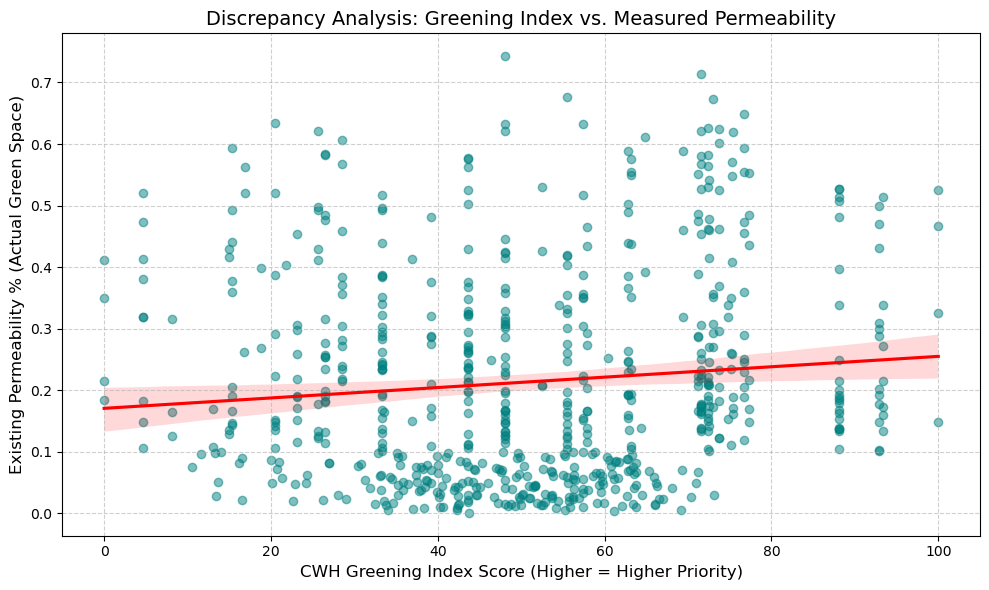

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the CSV
df = pd.read_csv('Green_Schoolyards_Category_Indexes.csv')

# 2. Clean headers to remove newlines (\n) and extra spaces
df.columns = df.columns.str.replace(r'\s+', ' ', regex=True).str.strip()

# Identify the columns based on your provided list
x_col = 'Combined Category 1 Score'
y_col = 'Schoolyard % Permeable'

# 3. Clean numeric data and handle repeated header rows
# errors='coerce' turns text artifacts into NaN so they can be dropped
df[y_col] = pd.to_numeric(df[y_col].astype(str).str.replace('%', ''), errors='coerce')
df[x_col] = pd.to_numeric(df[x_col], errors='coerce')

# Drop rows that don't have valid numbers in both columns
df = df.dropna(subset=[x_col, y_col])

# 4. Generate the Discrepancy Visual (Clean)
plt.figure(figsize=(10, 6))

# Simple regression plot without extra highlighting or annotations
sns.regplot(x=x_col, y=y_col, data=df, 
            scatter_kws={'alpha':0.5, 'color':'teal'}, 
            line_kws={'color':'red'})

# Formatting for professional presentation
plt.title('Discrepancy Analysis: Greening Index vs. Measured Permeability', fontsize=14)
plt.xlabel('CWH Greening Index Score (Higher = Higher Priority)', fontsize=12)
plt.ylabel('Existing Permeability % (Actual Green Space)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()